<a href="https://colab.research.google.com/github/chaeyeon2367/ml-python-studyML/blob/main/Ensemble%20Learning/Shap_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import dataset

In [6]:
# Data import
data = pd.read_csv("/content/drive/MyDrive/Ensemble learning/kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,20141013T000000,221900.0,3,1.00,1.0,0,3,7,1955,0,98178,47.5112,-122.257
1,6414100192,20141209T000000,538000.0,3,2.25,2.0,0,3,7,1951,1991,98125,47.7210,-122.319
2,5631500400,20150225T000000,180000.0,2,1.00,1.0,0,3,6,1933,0,98028,47.7379,-122.233
3,2487200875,20141209T000000,604000.0,4,3.00,1.0,0,5,7,1965,0,98136,47.5208,-122.393
4,1954400510,20150218T000000,510000.0,3,2.00,1.0,0,3,8,1987,0,98074,47.6168,-122.045


In [7]:

'''
id: Unique ID of the house
date: Date when the house was sold
price: House price (target variable)
bedrooms: Number of bedrooms per house
bathrooms: Number of bathrooms per house
floors: Total number of floors
waterfront: Whether the house has a waterfront view (0, 1)
condition: Condition of the house (1-5)
grade: Rating based on the King County grading system (1-13)
yr_built: Year the house was built
yr_renovated: Year the house was renovated
zipcode: Zip code
lat: Latitude
long: Longitude
'''

'\nid: Unique ID of the house\ndate: Date when the house was sold\nprice: House price (target variable)\nbedrooms: Number of bedrooms per house\nbathrooms: Number of bathrooms per house\nfloors: Total number of floors\nwaterfront: Whether the house has a waterfront view (0, 1)\ncondition: Condition of the house (1-5)\ngrade: Rating based on the King County grading system (1-13)\nyr_built: Year the house was built\nyr_renovated: Year the house was renovated\nzipcode: Zip code\nlat: Latitude\nlong: Longitude\n'

In [9]:
nCar = data.shape[0] # number of data
nVar = data.shape[1] # number of variables
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 21613 nVar: 14


## Pre-processing of data

### Remove variables deemed meaningless

In [10]:
data = data.drop(['id', 'date', 'zipcode', 'lat', 'long'], axis = 1) # id, date, zipcode, lat, long  제거

## Convert categorical variables to binary variables
- The categorical variable is only the waterfront column, and since it is a binary classification, it is expressed as 0, 1.
- Omit the process as it is expressed as 0, 1 in the data

## Separation of explanatory variables and target variables, and separation of training data and evaluation data

In [11]:
feature_columns = list(data.columns.difference(['price'])) # Price를 제외한 모든 행
X = data[feature_columns]
y = data['price']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42) # 학습데이터와 평가데이터의 비율을 7:3
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(15129, 8) (6484, 8) (15129,) (6484,)


## Predict Apartment Prices Using LightGBM (Regression)

In [12]:
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error
lgb_dtrain = lgb.Dataset(data = train_x, label = train_y)
lgb_param = {'max_depth': 10, # tree depth
            'learning_rate': 0.01, # Step Size
            'n_estimators': 1000, # Number of trees
            'objective': 'regression'} # Objective function (L2 Loss)
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # Process learning
lgb_model_predict = lgb_model.predict(test_x) # prediction of test data
print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, test_y)))) # RMSE

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 15129, number of used features: 8
[LightGBM] [Info] Start training from score 537729.263666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

## Use Shap Value to determine the attribution of each variable

In [13]:
!pip install shap

In [14]:
# !pip install shap (When an error occurs, skimage version check
# import skimage -> skimage.__version__ (skimage version check)
# skimage version upgrade -> !pip install --upgrade scikit-image
import shap
explainer = shap.TreeExplainer(lgb_model) # Specify tree model Shap Value calculation object
shap_values = explainer.shap_values(test_x) # Calculate Shap Values

In [15]:
import skimage
skimage.__version__

'0.19.3'

In [16]:
shap.initjs() # JavaScript initialization (graph initialization)
shap.force_plot(explainer.expected_value, shap_values[1,:], test_x.iloc[1,:]) # Visualize by applying Shap Value for the first instance of validation data
# Red has a high impact, blue has a low impact

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, test_x) # Applies to the entire validation dataset

shap.plots.force is slow for many thousands of rows, try subsampling your data.


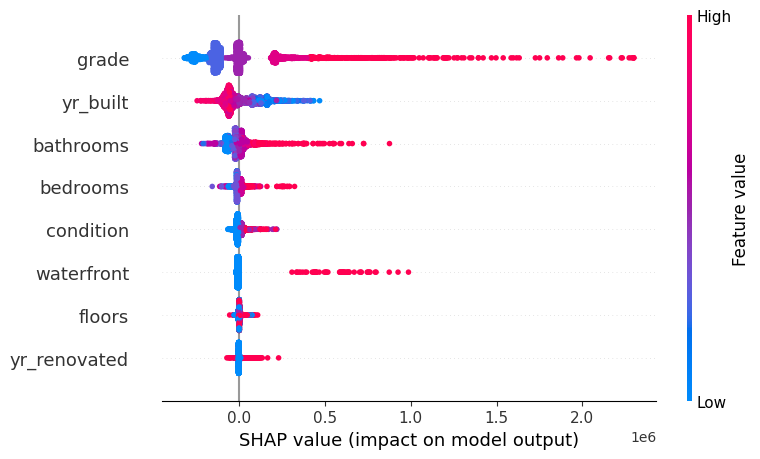

In [17]:
shap.summary_plot(shap_values, test_x)
# grade : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# yr_built : 변수의 값이 낮을 수록, 예상 가격이 높은 경향성이 있다.
# bathrooms : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# bedrooms : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# condition : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다
# waterfront : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# floors : 해석 모호성 (Feature Value에 따른 Shap Values의 상관성 파악 모호)
# yr_renovated : 해석 모호성 (Feature Value에 따른 Shap Values의 상관성 파악 모호)

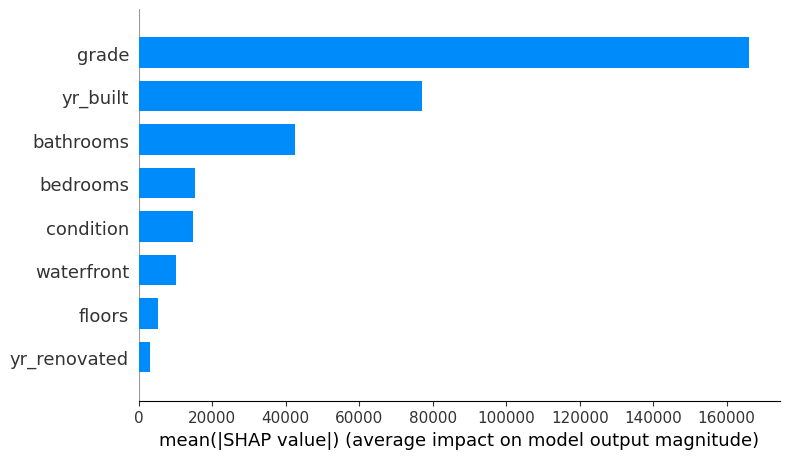

In [18]:
shap.summary_plot(shap_values, test_x, plot_type = "bar") # 각 변수에 대한 Shap Values의 절대값으로 중요도 파악

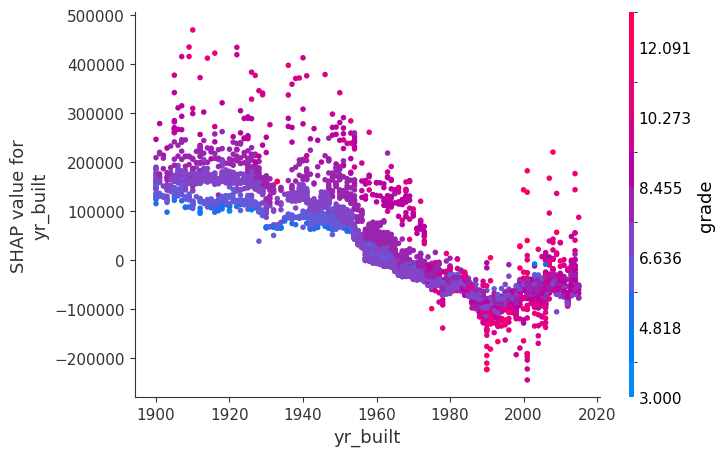

In [19]:
shap.dependence_plot("yr_built", shap_values, test_x)

In [ ]:
## https://github.com/slundberg/shap